In [7]:
# !pip install ISR
# !pip install 'h5py==2.10.0' --force-reinstall
# !pip install kaggle

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download scribbless/another-anime-face-dataset

In [67]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
import matplotlib.animation as animation
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from collections import namedtuple
from google.colab.patches import cv2_imshow
from PIL import Image
from ISR.models import RDN

## 1) Preparing dataset

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
!unzip './another-anime-face-dataset.zip' -d './dataset/'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./dataset/animefaces256cleaner/95164942_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95165813_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95165971_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95166952_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95168115_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95168345_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95169183_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95170809_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95171519_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95174091_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95175149_result.jpg  
  inflating: ./dataset/animefaces256cleaner/9517787_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95178265_result.jpg  
  inflating: ./dataset/animefaces256cleaner/95178272_result.jpg  
  inflati

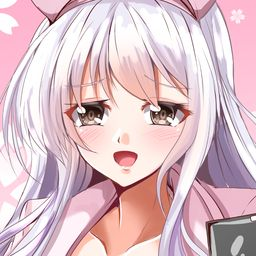

In [9]:
im = cv2.imread('./dataset/animefaces256cleaner/98501341_result.jpg')
cv2_imshow(im)

In [10]:
im.shape

(256, 256, 3)

In [11]:
image_size = 64
batch_size = 128
latent_size= 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)  

In [12]:
transformation = tt.Compose([tt.Resize(image_size), tt.ToTensor(), tt.CenterCrop(image_size), tt.Normalize(*stats)])

In [13]:
train = ImageFolder('./dataset/', transform = transformation)

In [14]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


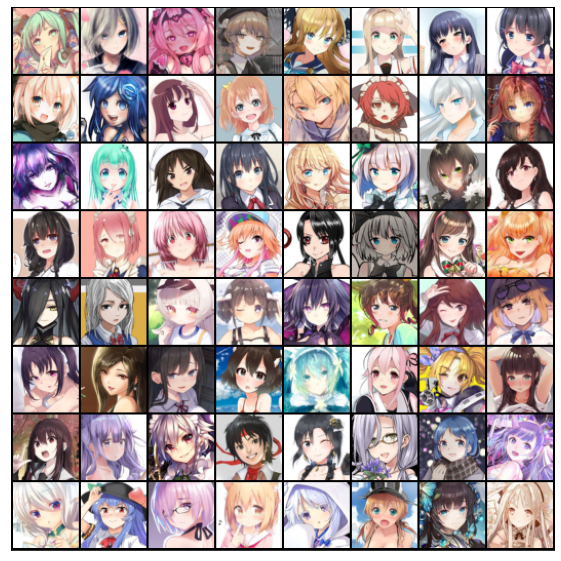

In [16]:
show_batch(train_dl)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

## 2) Creating generator and discriminator

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
discriminator = to_device(discriminator, device)

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


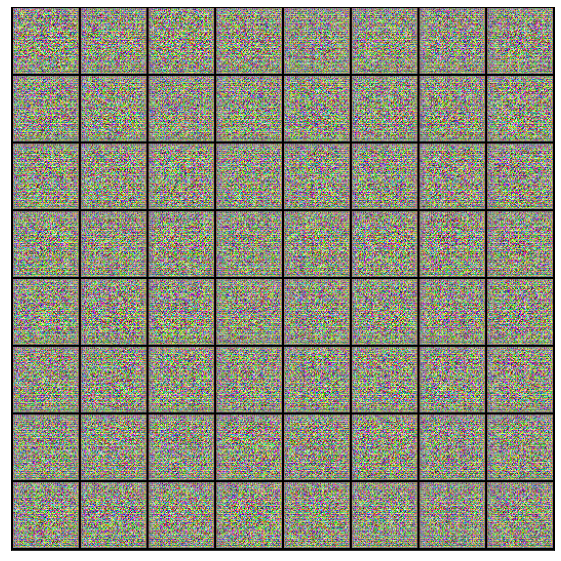

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:
sample_dir = './generated_img'
os.makedirs(sample_dir, exist_ok=True)

In [29]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


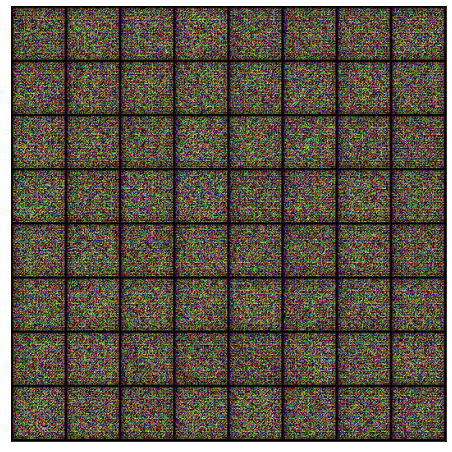

In [31]:
save_samples(0, fixed_latent)

In [32]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

        if epoch%2 == 0:
          torch.save(discriminator, './models_weights/discriminator.pth')
          torch.save(generator, './models_weights/generator.pth')

    
    return losses_g, losses_d, real_scores, fake_scores

## 3) Loading models weights and training

In [41]:
discriminator = torch.load('./models_weights/discriminator.pth')

In [47]:
generator = torch.load('./models_weights/generator.pth')

In [52]:
lr = 0.01
epochs = 1

In [53]:
history = fit(epochs, lr)

  0%|          | 0/721 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/1], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0001.png


## 4) Result of generation

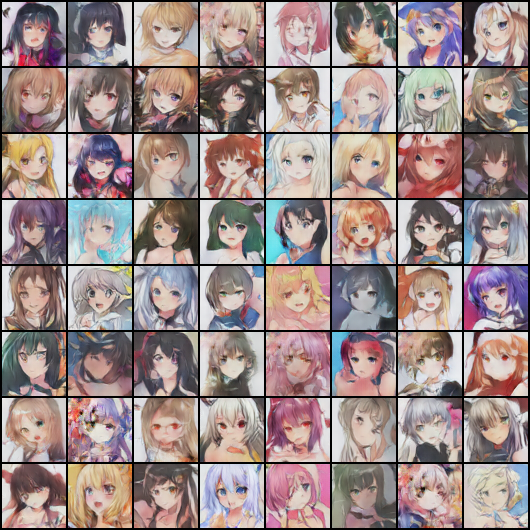

In [4]:
Image.open('./generated_images/best.png')

## 5) Cropping

In [54]:
os.mkdir(f'cropped')

In [61]:
def cropped(original_image_path):
  im = Image.open(original_image_path) 
  cropped_image_size = 64
  batch_size = 64
  frame_width = 2 # width of a frame around each image
  left = 1 # setting starting coordinates
  top = 1 # setting starting coordinates
  right = left + cropped_image_size + frame_width # setting starting coordinates
  bottom = top + cropped_image_size  + frame_width # setting starting coordinates
  index = 1
  for i in range(64):
      if right < im.size[0]:
          img = im.crop((left, top, right, bottom))
          name = 'image-{0:0=4d}.png'.format(index)
          left += cropped_image_size + frame_width
          right += cropped_image_size + frame_width
          top = top
          bottom= bottom
      if right >= im.size[0]:
          left = 1
          top += cropped_image_size + frame_width
          right = left + cropped_image_size + frame_width
          bottom = top + cropped_image_size + frame_width
      index += 1
      img.save(f'./cropped/'+ name, 'PNG')

## 6) Transform to art

In [62]:
cropped('./generated_img/best.png')

In [73]:
def RDN_func(image_path):
    rdn = RDN(weights='noise-cancel')

    image = Image.open(image_path)
    display(image)

    first = rdn.predict(np.array(image))
#   first = Image.fromarray(first)

    second = rdn.predict(np.array(first))
#   second = Image.fromarray(second)

    third = rdn.predict(np.array(second))

    display(Image.fromarray(third))
    return image, third

In [76]:
for file in os.listdir('./cropped'):
    RDN_func('./cropped/' + file)

Output hidden; open in https://colab.research.google.com to view.

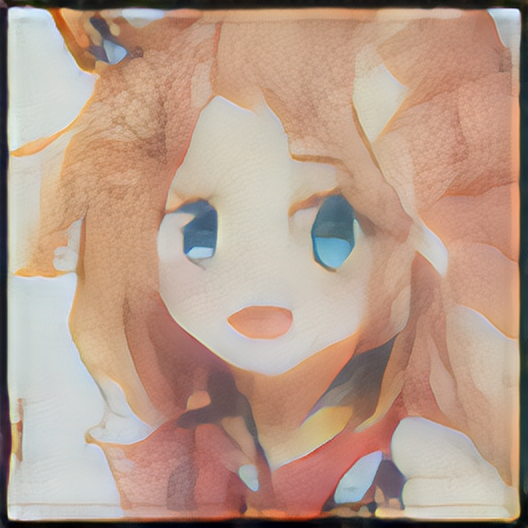

In [6]:
Image.open('./arts/1.png')